## Alignment

In [39]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython.display as display
from scipy.spatial import Delaunay

# Make our plots a little nicer
mpl.rcParams['figure.figsize'] = (8, 8)

In [40]:
# Trained on ???
face_detector = cv2.CascadeClassifier('haarcascade_face_classifier.xml')

# Trained on the 300-W dataset
landmark_detector  = cv2.face.createFacemarkLBF()
landmark_detector.loadModel('lbfmodel.yaml')

In [41]:
def get_landmarks(img):
    '''Get landmarks from the portriat image.'''
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(img_gray)
    if len(faces) == 0:
        print('error: no faces detected')
        raise Error()
    if len(faces) > 1:
        print('warning: multiple faces detected')
    _, landmarks = landmark_detector.fit(img_gray, faces)
    arr = landmarks[0].reshape(-1, 2)
    
    h, w = img_gray.shape
    h = h - 0.5
    w = w - 0.5
    border_points = [[0, 0], [w, 0], [0, h], [w, h], [w / 2, 0],
                     [0, h / 2], [w, h / 2], [w / 2, h]]
    
    return np.float32(np.vstack((arr, border_points)))

def show_img(img, title='Look an image!'):
    '''Use OpenCV to display an image in a window.'''
    cv2.imshow(title, img)
    cv2.waitKey(0)

def plot_img(img):
    '''Plot an OpenCV image in matplotlib.'''
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def plot_landmarks(img, landmarks, show_tri=False):
    '''Plot image with landmarks and triangulation.'''
    if show_tri:
        plt.triplot(landmarks[:,0], landmarks[:,1], triangulate(landmarks))
    plt.plot(landmarks[:, 0], landmarks[:, 1], 'o')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def triangulate(points):
    '''Do Delauny triangulation on a (-1, 2) array of points.'''
    return Delaunay(points).simplices
    
def offset_tri(tri, rect):
    '''Offset points in triangle using a rectangle.'''
    rect_x, rect_y, _, _ = rect
    return [(x - rect_x, y - rect_y) for x, y in tri]

def rect_slice(rect):
    '''Get a slice that iterates only over what is in the rect.'''
    x, y, w, h = rect
    return (slice(y, y + h), slice(x, x + w))
    
def warp_affine(img, src_tri, dst_tri, size):
    '''Create and apply an affine transform with src_tri and dst_tri correspondence points.'''
    warp = cv2.getAffineTransform(np.float32(src_tri), np.float32(dst_tri))
    return cv2.warpAffine(img, warp, size, None, flags=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_REFLECT_101)
    
def warp_face(src_img, dst_img):
    '''
    Warp the Delaunay triangles made from landmark points of the src_img to those of the
    dst_img. Similiar to https://github.com/spmallick/learnopencv/blob/master/FaceMorph/faceMorph.py
    '''
    src_landmarks = get_landmarks(src_img)
    dst_landmarks = get_landmarks(dst_img)
    out_img = np.zeros(dst_img.shape, dtype=np.float32)
    
    # Iterate through the Delaunay triangles
    for landmark_index in triangulate(dst_landmarks):
        src_tri = src_landmarks[landmark_index]
        dst_tri = dst_landmarks[landmark_index]
        
        # Bound each triangle with a rectangle
        src_rect = cv2.boundingRect(src_tri)
        dst_rect = cv2.boundingRect(dst_tri)
        _, _, dst_width, dst_height = dst_rect

        # Offset
        src_tri = offset_tri(src_tri, src_rect)
        dst_tri = offset_tri(dst_tri, dst_rect)

        # Get mask by filling in triangle
        mask = np.zeros((dst_height, dst_width, 3), dtype=np.float32)
        cv2.fillConvexPoly(mask, np.int32(dst_tri), (1, 1, 1), 16, 0)
        
        # Crop the input images with the bounding boxes
        src_img_cropped = src_img[rect_slice(src_rect)]

        # Apply the affine transformation
        warped = warp_affine(src_img_cropped, src_tri, dst_tri, (dst_width, dst_height))

        # Copy triangular region of the rectangular patch to the output image
        out_img[rect_slice(dst_rect)] = out_img[rect_slice(dst_rect)] * (1 - mask) + warped * mask
        
    return np.uint8(out_img)

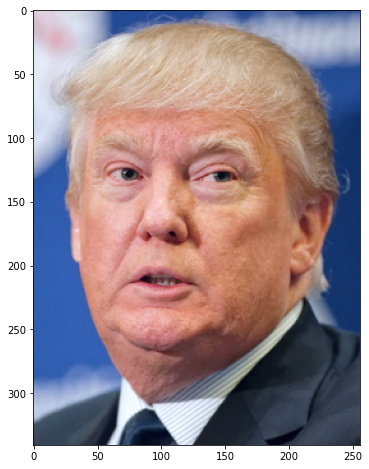

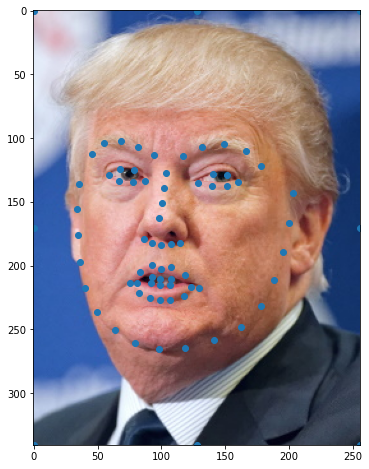

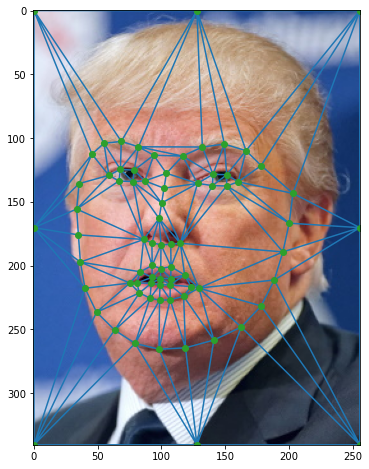

In [42]:
img = cv2.imread('images/donald_trump.jpg')
plot_img(img)
plot_landmarks(img, get_landmarks(img))
plot_landmarks(img, get_landmarks(img), show_tri=True)

In [43]:
# img = cv2.imread('images/painting5.jpg')
# plot_img(img)
# plot_landmarks(img, get_landmarks(img))
# plot_landmarks(img, get_landmarks(img), show_tri=True)

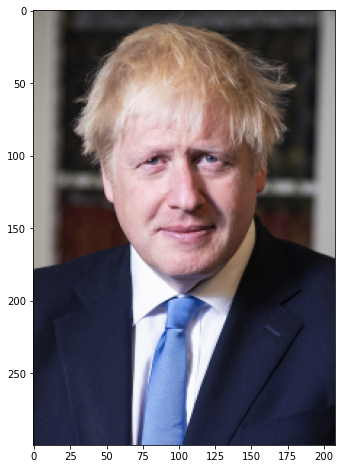

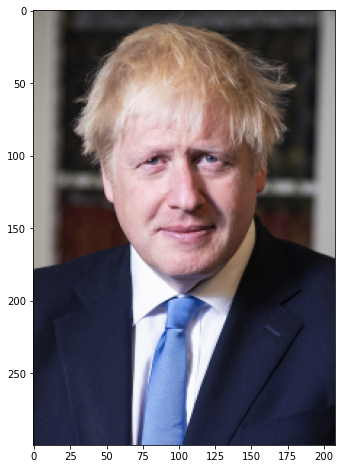

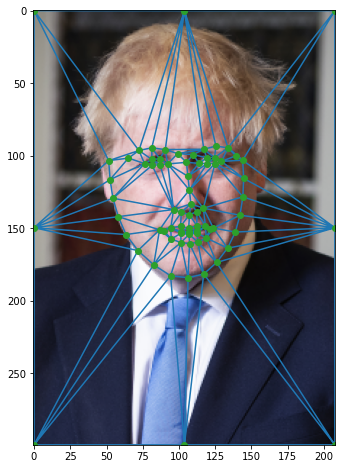

In [44]:
# Try it out with some people who already have weird faces
a_img = cv2.imread('images/boris_johnson.jpg')
# b_img = cv2.imread('images/donald_trump.jpg')
plot_img(a_img)
plot_img(b_img)

# warped_img = warp_face(a_img, b_img)
landmarks = get_landmarks(a_img)
plot_landmarks(a_img, landmarks, show_tri=True)

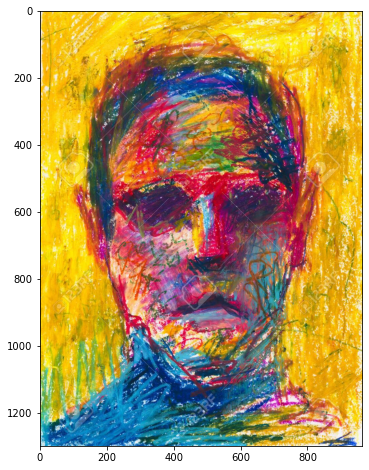

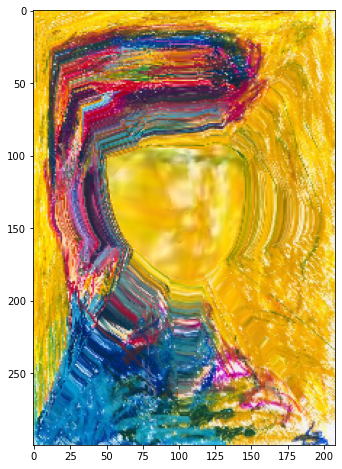

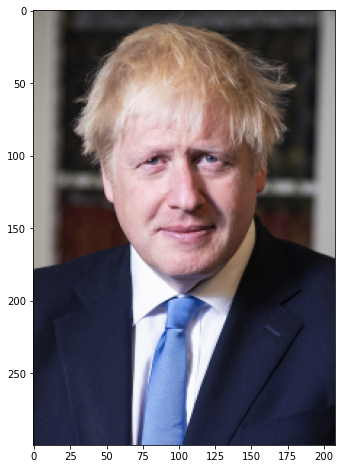

True

In [47]:
PAINTING_NAME = 'painting10'
PHOTO_NAME    = 'boris_johnson'
OUTPUT_NAME   = 'output_ted_cruz_painting8'

# Warp our painting's to the photo's face and save
# (TensorFlow and OpenCV have different ways of handeling images
# so it easier to just save and reopen the image.)
a_img = cv2.imread('images/{}.jpg'.format(PAINTING_NAME))
b_img = cv2.imread('images/{}.jpg'.format(PHOTO_NAME))
a_warped = warp_face(a_img, b_img)
plot_img(a_img)
plot_img(a_warped)
plot_img(b_img)
cv2.imwrite('images/{}_warped.jpg'.format(PAINTING_NAME), a_warped)

## Style Transfer

In [31]:
import tensorflow as tf
import PIL.Image
import time
import functools
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [32]:
# These 4 functions are (modified) versions of some found here
# https://www.tensorflow.org/tutorials/generative/style_transfer
# But our approach is not the same as the guide.

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return tensor

def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

def vgg_layers(layer_names):
    vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    return keras.Model([vgg.input], outputs)

In [33]:
def to_feature_map(output):
    '''
    Reshape a layer's output to a NxD matrix where N is the number of filters
    and D is every filter activation for that filter.
    '''
    n_channels = output.shape[3]
    return tf.reshape(output, (n_channels, -1))

def to_feature_maps(outputs):
    '''Take a list of layer outputs to a list of feature maps.'''
    return [to_feature_map(output) for output in outputs]

def to_gain_map(s_activations, c_activations, epsilon=10e-4):
    assert s_activations.shape == c_activations.shape
    return s_activations / (c_activations + epsilon)

def clamp(arr_like, g_min=0.7, g_max=5):
    return tf.clip_by_value(arr_like, clip_value_min=g_min, clip_value_max=g_max)

def apply_gain_map(activations, gain_map):
    assert activations.shape == gain_map.shape
    return activations * clamp(gain_map)

def modify_map(s_activations, c_activations):
    '''
    This takes in style and content feature maps and creates F[M] using a
    created gain map.
    '''
    gain_map = to_gain_map(s_activations, c_activations)
    return apply_gain_map(c_activations, gain_map)

class PortraitModel(keras.models.Model):
    def __init__(self, layers):
        super(PortraitModel, self).__init__()
        self.vgg = vgg_layers(layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        inputs = tf.image.resize(inputs * 255.0, (224, 224))
        inputs = keras.applications.vgg19.preprocess_input(inputs)
        return self.vgg(inputs)
    
def rand_img(w, h, c):
    arr = np.zeros((w, h))
    arr = cv2.randu(arr, 0.5, 0.1)
    arr = np.dstack([arr] * c)
    arr = tf.convert_to_tensor(arr, dtype=tf.float32)
    return arr[tf.newaxis, :]

def gray_img(w, h, c, intensity):
    assert intensity >= 0 and intensity <= 1
    arr = np.zeros((w, h))
    arr = cv2.randu(arr, 0.5, 0.1)
    arr = np.dstack([arr] * c)
    arr = tf.convert_to_tensor(arr, dtype=tf.float32)
    return arr[tf.newaxis, :]

In [34]:
# Hyperparams
GAMMA  = 50
LAYERS = ['block3_conv1', 'block4_conv1']
ALPHAS = [0.5, 0.5]
BETAS  = [0.5, 0.5]

def loss_fn(layer_outputs, s_targets, m_targets):
    '''Loss function as described in the paper.'''
    outputs = to_feature_maps(layer_outputs)
    
    loss1, loss2 = 0, 0
    
    for o, m, alpha in zip(outputs, m_targets, ALPHAS):
        N = o.shape[0]
        D = o.shape[1]
        loss1 += alpha * (1 / (2 * N * D)) * tf.reduce_sum(((o - m) ** 2))
    
    for o, s, beta in zip(outputs, s_targets, BETAS):
        N = o.shape[0]
        diff = tf.linalg.matmul(o, o, transpose_b=True) - tf.linalg.matmul(s, s, transpose_b=True)
        loss2 += beta * (1 / (2 * (N ** 2))) * tf.reduce_sum(diff ** 2)
    
    return loss1 + (GAMMA * loss2)

In [35]:
# Load our target style and content images
# We load in the warped image directy from the alignment stage above.
s_img = tf.constant(load_img('images/{}_warped.jpg'.format(PAINTING_NAME)))
c_img = tf.constant(load_img('images/{}.jpg'.format(PHOTO_NAME)))

# Make a random image for the output
_, w, h, c = c_img.shape
output_img = tf.Variable(rand_img(w, h, c))

# Create our model
extractor = PortraitModel(LAYERS)

# Extract target feature maps
s_targets = to_feature_maps(extractor(s_img))
c_targets = to_feature_maps(extractor(c_img))
m_targets = [modify_map(s, c) for s, c in zip(s_targets, c_targets)]

# Optimizer. Adjusting some of these settings may help
opt = tf.optimizers.Adam(learning_rate=0.08)

@tf.function()
def train_step(img, s_targets, m_targets):
    with tf.GradientTape() as tape:
        outputs = extractor(img)
        loss = loss_fn(outputs, s_targets, m_targets)
    grad = tape.gradient(loss, img)
    opt.apply_gradients([(grad, img)])
    img.assign(clamp(img, g_min=0, g_max=1))

In [36]:
def write_video(frames, filename):
    w, h, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video = cv2.VideoWriter(filename, fourcc, 1, (w, h))
    for frame in frames:
        video.write(frame)
    cv2.destroyAllWindows()
    video.release()

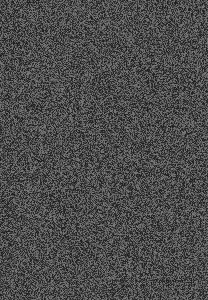

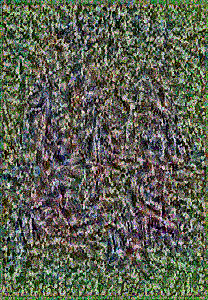

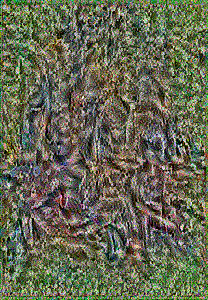

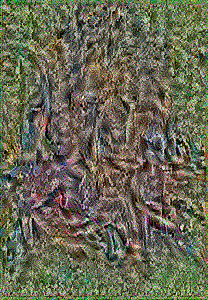

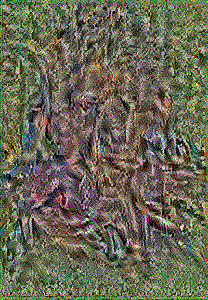

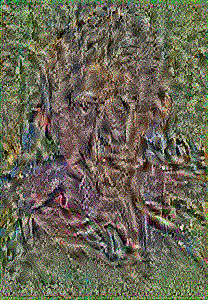

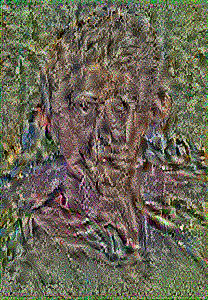

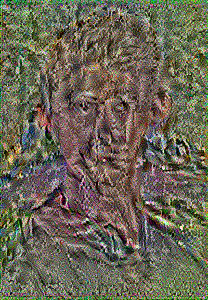

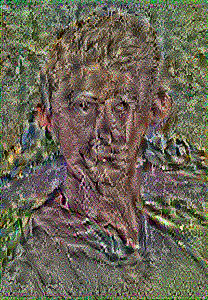

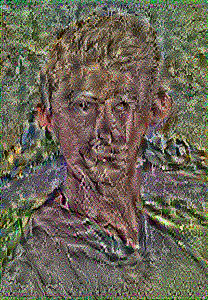

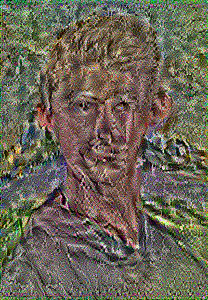

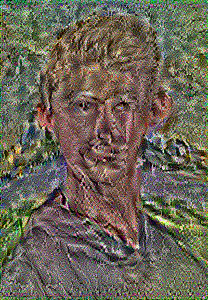

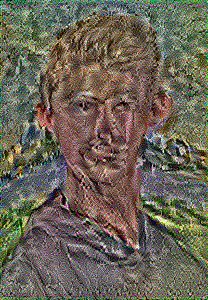

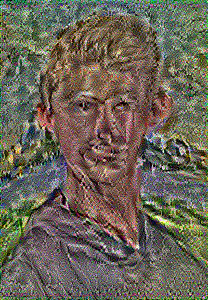

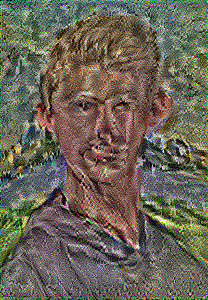

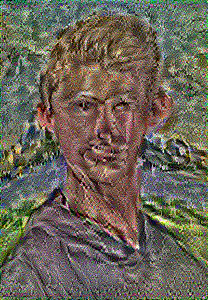

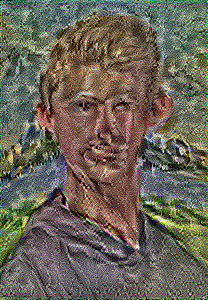

ResourceExhaustedError:  OOM when allocating tensor with shape[1,12544,1152] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node gradient_tape/portrait_model_1/model_1/block2_conv2/Conv2DBackpropInput (defined at <ipython-input-35-e1992ff71c06>:26) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_step_4505]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/portrait_model_1/model_1/block2_conv2/Conv2DBackpropInput:
 portrait_model_1/model_1/block2_conv2/Conv2D/ReadVariableOp (defined at <ipython-input-11-5f62b5dcf73c>:41)

Function call stack:
train_step


In [ ]:
start = time.time()

# Somewhere between 300 and 400 iterations seems to work best
epochs = 20
steps_per_epoch = 20

display.display(tensor_to_image(output_img))

frames = []
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        frames.append(to_image(output_img))
        train_step(output_img, s_targets, m_targets)
    display.display(tensor_to_image(output_img))

print('Total time: {:.1f}'.format(time.time() - start))

write_video('video.avi', frames)

# Write image to file
filename = '{}.jpg'.format(OUTPUT_NAME)
cv2.imwrite(filename, cv2.cvtColor(to_image(output_img), cv2.COLOR_RGB2BGR))

In [16]:
len(frames)

601

In [21]:
# for i, frame in enumerate(frames):
#     cv2.imwrite('frames/frame_{}.jpg'.format(i), cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

In [22]:
write_video(frames, 'video.avi')